In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
from scipy import special, integrate
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as astrocosmo
from colossus.cosmology import cosmology
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

We can approximate the linear angular power spectrum as
$$
C(\ell) \approx \frac{\Delta\chi}{\chi^2(\bar z)}\,W_\mathrm{phot}(\chi)\,W_i\,b_\mathrm{phot}(\bar z)\,b_i(\bar z) \,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$

where $\chi$ is comoving distance and $\bar z$ is the redshift of the snapshot.

$W$ are the weights:
$$
W_\mathrm{phot} = \frac{1}{N_\mathrm{phot}}\frac{\mathrm{d}N_\mathrm{phot}}{\mathrm{d}\chi}
$$

$$
W_i = \frac{1}{\Delta\chi}\quad \mathrm{if}\quad -\frac{\Delta\chi}{2}+\chi_i\leq\chi\leq\chi_i + \frac{\Delta\chi}{2}
$$

$b$ is the linear bias which we can estimate from
$$
b = \frac{w_\mathrm{Gal\ x\ DM}(\theta)}{w_\mathrm{lin}(\theta)}
$$

### functions

In [3]:
def perh():
    return (astrocosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [4]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / astrocosmo.H(z) * perh()

In [5]:
def eval_Gaussian(loc, sigma, mean=0.):
    # pre = 1 / (sigma * np.sqrt(2 * np.pi))
    pre = 1 / sigma.unit if hasattr(sigma, 'unit') else 1
    exp = -(loc-mean)**2 / (2 * sigma**2)
    return pre * np.e**exp

In [6]:
def redshift_to_comov(z, cosmo=astrocosmo):
    r = astrocosmo.comoving_distance(z) * perh() # convert to Mpc/h
    return r

In [7]:
def ell_to_k(ell):
    return (ell + 0.5) / r.value
def k_to_ell(k):
    return (k * r.value) - 0.5

In [8]:
# convert Cartesian (x,y,z) coords in the box to (RA,Dec) on the sky from our observer pos,
#   given the distance to the box center
def CartesiantoEquatorial(pos, observer=[0,0,0]):
    x, y, z = (pos - np.array(observer)).T
    s = np.hypot(z, y) 
    lon = np.arctan2(y, z)
    lat = np.arctan2(x, s)

    # convert to degrees
    lon = np.rad2deg(lon)
    lat = np.rad2deg(lat)
    # wrap lon to [0,360]
    lon = np.mod(lon-360., 360.)
    return lon, lat

In [9]:
def wtheta_cross(ra1, dec1, ra2, dec2, ra_rand2, dec_rand2, bins, nthreads=12):
    nd1 = len(ra1)
    nd2 = len(ra2)
    nr2 = len(ra_rand2)
    binavg = 0.5 * (bins[1:] + bins[:-1])
    
    # D1D2
    D1D2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra2, DEC2=dec2)
    # D1R2
    D1R2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra_rand2, DEC2=dec_rand2)
    
    d1d2 = np.array([x['npairs'] for x in D1D2_counts]) / (nd1 * nd2)
    d1r2 = np.array([x['npairs'] for x in D1R2_counts]) / (nd1 * nr2)
    
    wtheta = np.empty(nbins)
    wtheta[:] = np.nan
    wtheta = np.divide(d1d2, d1r2, where=(d1r2!=0.), out=wtheta) - 1
    
    return binavg, wtheta

In [10]:
def xi_cross(data1, data2, rand2, bins, boxsize=None, nthreads=12, periodic=True, dtype='float32'):
    
    # params
    binavg = 0.5 * (bins[1:] + bins[:-1])
    xd1, yd1, zd1 = data1.T.astype(dtype)
    xd2, yd2, zd2 = data2.T.astype(dtype)
    xr, yr, zr = rand2.T.astype(dtype)
    boxsize = boxsize if boxsize is not None else (np.amax(xr)-np.amin(xr)).astype(dtype)
    
    # compute pair counts
    d1d2_res = DD(0, nthreads, bins, xd1, yd1, zd1, X2=xd2, Y2=yd2, Z2=zd2,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    d1r2_res = DD(0, nthreads, bins, xd1, yd1, zd1, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    d1d2 = np.array([x['npairs'] for x in d1d2_res], dtype=dtype)
    d1r2 = np.array([x['npairs'] for x in d1r2_res], dtype=dtype)
    
    ndpairs = len(data1) * len(data2)
    nrpairs = len(data1) * len(rand2)
    
    counts = np.divide(d1d2, d1r2, where=(d1r2!=0.), out=np.zeros_like(d1d2), dtype=dtype)
    
    return binavg, nrpairs / ndpairs * counts - 1

In [11]:
def xi_auto(data, rand, bins, boxsize=None, nthreads=12, periodic=True, dtype='float32'):
    
    # params
    binavg = 0.5 * (bins[1:] + bins[:-1])
    xd, yd, zd = data.T.astype(dtype)
    xr, yr, zr = rand.T.astype(dtype)
    boxsize = boxsize if boxsize is not None else (np.amax(xr)-np.amin(xr)).astype(dtype)
    
    # compute pair counts
    dd_res = DD(1, nthreads, bins, xd, yd, zd,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    dr_res = DD(0, nthreads, bins, xd, yd, zd, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    dd = np.array([x['npairs'] for x in dd_res], dtype=dtype)
    dr = np.array([x['npairs'] for x in dr_res], dtype=dtype)
    
    ndpairs = len(data) * (len(data)-1)
    nrpairs = len(rand) * len(data)
    
    counts = np.divide(dd, dr, where=(dr!=0.), out=np.zeros_like(dd), dtype=dtype)
    
    return binavg, nrpairs / ndpairs * counts - 1

In [12]:
def wlin(theta, ell, Cell):
    
    assert ell.ndim == Cell.ndim == 1

    # # function of ell that we want to integrate
    # def ell_func(ell_, Cell_):
    #     return (ell_ / (2 * np.pi)) * Cell_ * (special.jv(0, ell_ * theta))

    # construct our array, and integrate using trapezoid rule
    ell_func_arr = np.array([
        ell / (2 * np.pi) * Cell * special.jv(0, ell * theta)
    ]).flatten()
    trapz = integrate.trapz(ell_func_arr, x=ell)

    return trapz, ell_func_arr

### construct samples

In [13]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)
sigma_z = 0.01  # one of the 5 redshift error bins in SPHEREx

**spectroscopic sample:** SPHEREx-like galaxies from TNG; spans 3D box

In [14]:
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


**photometric sample:** SPHEREx-like galaxies from TNG at the target redshift; selected from spectroscopic sample with a Gaussian centered at the box center

In [15]:
# dx = the standard deviation of the distance spread along the LOS
dx = get_dx(redshift, sigma_z)
dx

<Quantity 34.14988849 Mpc / littleh>

In [16]:
# select galaxies from the spectroscopic sample with a Gaussian PDF
gal_pos_phot = []
for i, pos in enumerate(gal_pos_spec):
    draw = eval_Gaussian(pos[2], dx) * dx.unit
    if draw > np.random.uniform():
        gal_pos_phot.append(pos)
    else:
        continue
gal_pos_phot = np.array(gal_pos_phot) * dx.unit

### linear matter power spectrum

In [17]:
# comoving distance to the box center
r = redshift_to_comov(redshift)
# multipoles
ell = np.logspace(0, 6, 1000)
r

<Quantity 1317.92319893 Mpc / littleh>

In [18]:
# power spectrum from colossus
cosmo = cosmology.setCosmology('planck15')
P = cosmo.matterPowerSpectrum(ell_to_k(ell), redshift)

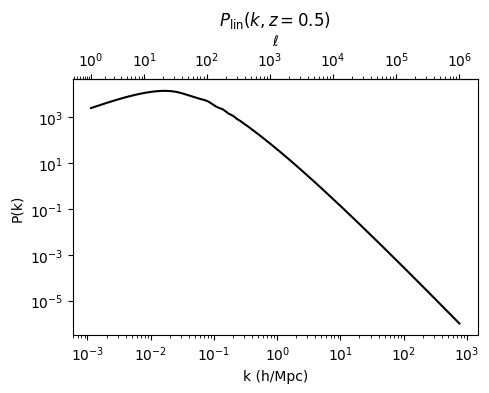

In [19]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(ell_to_k(ell), P, 'k-')
secax = ax.secondary_xaxis('top', functions=(k_to_ell, ell_to_k))
secax.set_xlabel(r'$\ell$')
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('P(k)')
ax.loglog()
ax.set_title(r'$P_\mathrm{lin}(k,z=$'+f'{redshift:.1f})')
fig.tight_layout()

### bias: Gal x DM / linear

In [20]:
# underlying dark matter
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100)
# corresponding random set
L = sim.boxsize.value
rand_pos = np.random.uniform(-L/2, L/2, (len(dm_pos),3))

In [21]:
# separation bins
nbins = 20
r_edges = np.logspace(np.log10(1), np.log10(100.), nbins+1)

In [22]:
# spectroscopic x DM
# shift all positions to 0-L to meet Corrfunc input requirements
d1 = gal_pos_spec.value + L/2
d2 = dm_pos.value
r2 = rand_pos + L/2
ravg, xix_spec = xi_cross(d1, d2, r2, r_edges, boxsize=L)

In [23]:
# linear theory from Colossus
xi_lin = tools.linear_2pcf(redshift, ravg)

In [24]:
# ratios
bs_spec = xix_spec / xi_lin

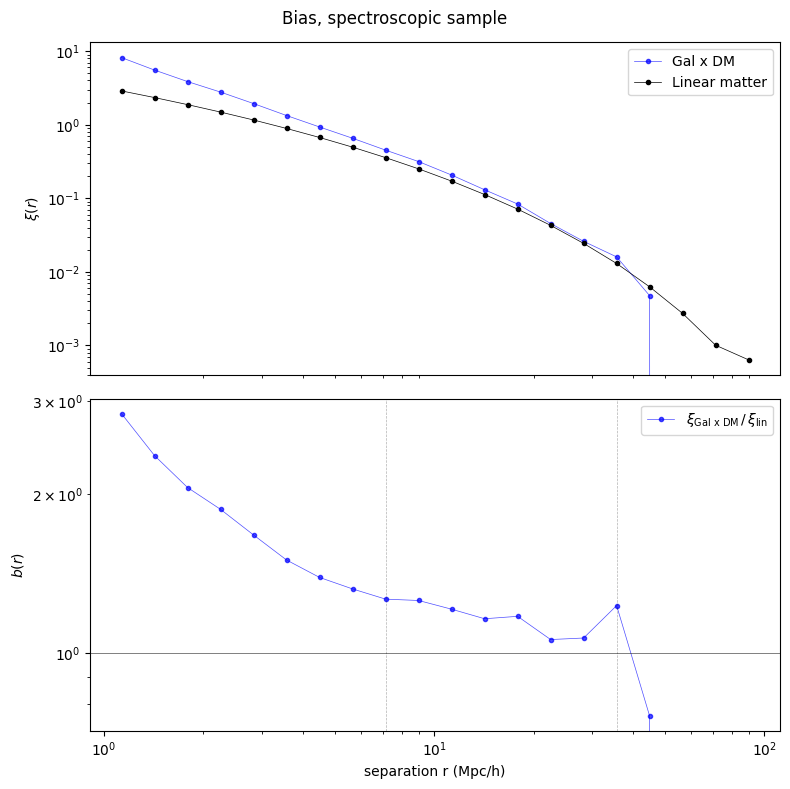

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(8,8))
axs[0].plot(ravg, xix_spec, 'b.-', lw=0.5, alpha=0.7, label='Gal x DM')
axs[0].plot(ravg, xi_lin, 'k.-', lw=0.5, label='Linear matter')
axs[0].set_ylabel(r'$\xi(r)$')

axs[1].plot(ravg, bs_spec, 'b.-', lw=0.5, alpha=0.7, label=r'$\xi_\mathrm{Gal\ x\ DM}\,/\,\xi_\mathrm{lin}$')
axs[1].axhline(1., c='k', lw=0.5, alpha=0.7)
axs[1].axvline(ravg[8], ls='--', c='k', lw=0.5, alpha=0.3)
axs[1].axvline(ravg[-5], ls='--', c='k', lw=0.5, alpha=0.3)
axs[1].set_ylabel(r'$b(r)$')
axs[1].set_xlabel('separation r (Mpc/h)')

for ax in axs:
    ax.loglog()
    ax.legend()
axs[0].set_xticks([])
fig.suptitle('Bias, spectroscopic sample')
fig.tight_layout()

In [26]:
b_spec = np.mean(bs_spec[8:-5])
b_spec

1.1694892966354522

### weights

**slices**

In [27]:
# divide into narrow 2D slices along the LOS
nslices = 11
losbins = np.linspace(-L/2, L/2, nslices+1) << u.Mpc / cu.littleh
slicewidth = (losbins[1]-losbins[0]) << u.Mpc / cu.littleh
slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << u.Mpc / cu.littleh

**photometric:** # photometric galaxies in each slice / total # of photometric galaxies

In [28]:
slices_phot = [
    gal_pos_phot[(losbins[i] <= gal_pos_phot[:,2]) & (gal_pos_phot[:,2] < losbins[i+1])] \
    for i in range(nslices)
]

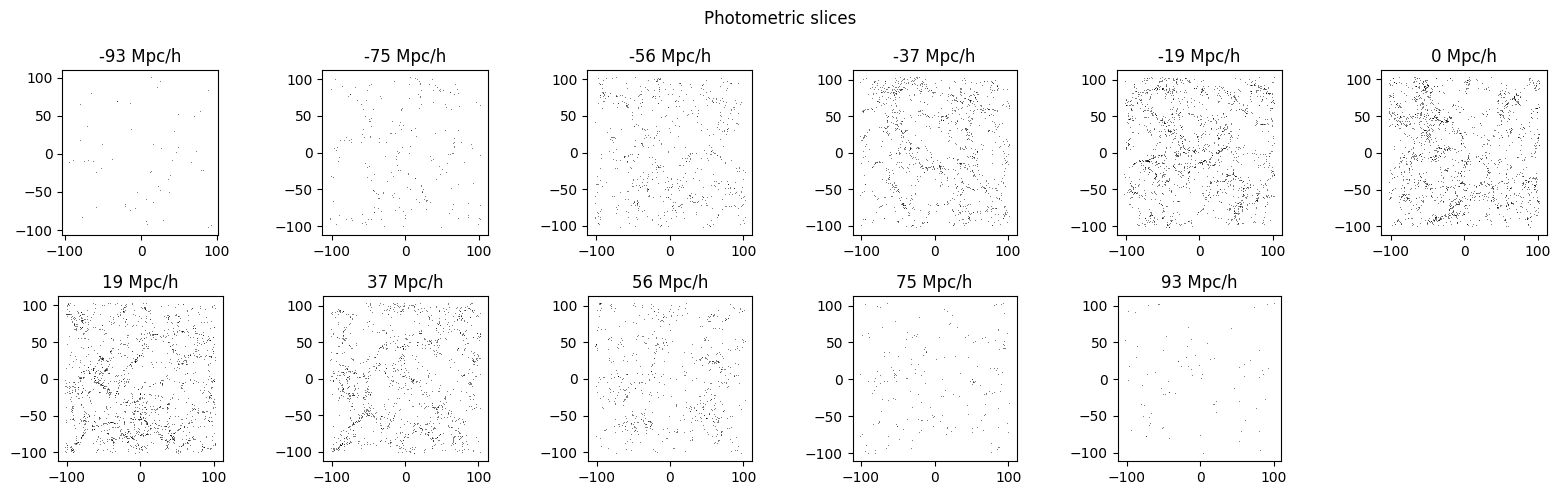

In [29]:
fig = plt.figure(figsize=(16,5))
axs = {}
for i, slice_ in enumerate(slices_phot):
    axs[i] = fig.add_subplot(2,6,i+1)
    axs[i].plot(slice_[:,0], slice_[:,1], marker=',', ls='None', c='k', alpha=0.5)
    axs[i].set_aspect('equal')
    axs[i].set_title(f'{slice_centers[i].value:.0f} Mpc/h')
fig.suptitle('Photometric slices')
fig.tight_layout()

In [32]:
Nphot = len(gal_pos_phot)
dNdchi = np.array([len(x) for x in slices_phot]) / slicewidth
W_phot = 1 / Nphot * dNdchi

In [62]:
np.sum(W_phot * slicewidth)

<Quantity 1.>

**spectroscopic:** each slice is equally weighted

In [34]:
slices_spec = [
    gal_pos_spec[(losbins[i] <= gal_pos_spec[:,2]) & (gal_pos_spec[:,2] < losbins[i+1])] \
    for i in range(nslices)
]

### linear angular power spectrum

Define a prefactor as all the terms that are independent of the LOS slice.

For now the photometric bias is the same as the spectroscopic bias, since the photometric sample is constructed from the spectroscopic sample.

In [50]:
prefactor = 1 / r**2 * b_spec**2 * P
C_ells = np.array([
    prefactor * W_phot[i] for i in range(nslices)
])

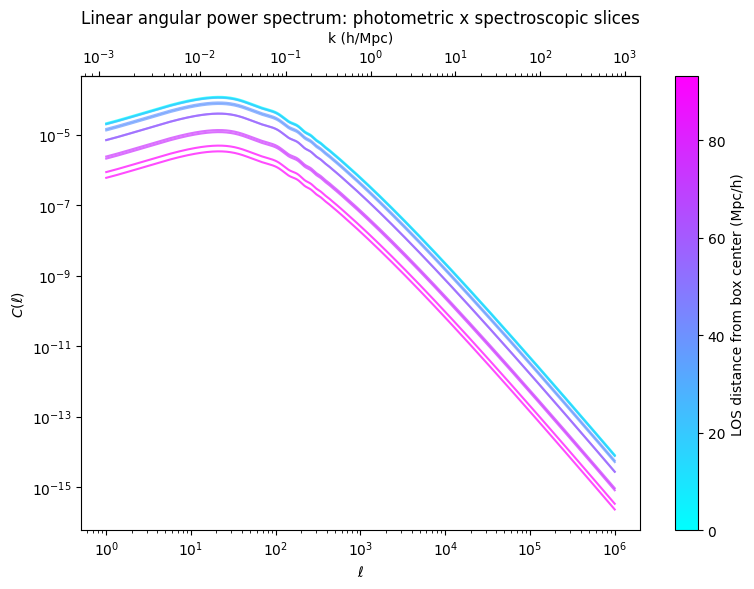

In [51]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(cmap='cool', norm=norm)

fig, ax = plt.subplots(figsize=(8,6))
for i, C_ell in enumerate(C_ells):
    ax.plot(ell, C_ell, '-', alpha=0.7, c=smap.to_rgba(np.abs(slice_centers[i].value)))
ax.loglog()
secax = ax.secondary_xaxis('top', functions=(ell_to_k, k_to_ell))
secax.set_xlabel('k (h/Mpc)')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C(\ell)$')
fig.colorbar(smap, ax=ax, label='LOS distance from box center (Mpc/h)')
ax.set_title('Linear angular power spectrum: photometric x spectroscopic slices')
fig.tight_layout()

### power spectrum $\rightarrow\ w_\mathrm{lin}(\theta)$

$$
w_\mathrm{lin}(\theta) = \int \frac{\mathrm{d}\ell\,\ell}{2\pi} J_0(\ell\theta)\,C(\ell)
$$

In [52]:
theta = np.deg2rad(np.logspace(np.log10(0.001), np.log10(5.), 20))
wlin_, ell_func_arr = wlin(theta[10], ell, C_ells[5])

Text(0.5, 1.0, 'Example integration, $\\theta=$1.54e-03 rad')

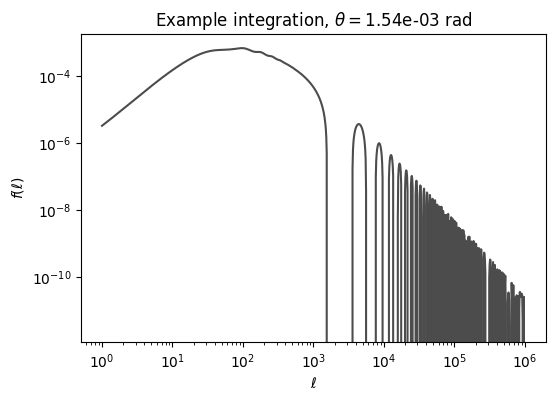

In [53]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ell, ell_func_arr, 'k-', alpha=0.7)
ax.loglog()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$f(\ell)$')
ax.set_title(r'Example integration, $\theta=$'+f'{theta[10]:.2e} rad')

In [54]:
wlin_

0.24472051441642645

In [55]:
wlin_pred = np.zeros((nslices,len(theta)))
for i, Cell in enumerate(C_ells):
    wlin_pred[i] = np.array([
        wlin(theta_, ell, Cell)[0] for theta_ in theta
    ])

### compute $w_\mathrm{lin}(\theta)$ from data

**convert Cartesian to (RA,Dec)**, setting all LOS positions to the box center

In [56]:
# full spectroscopic sample
gal_pos = np.copy(gal_pos_spec.value)
gal_pos[:,2] = 0
ra_spec, dec_spec = CartesiantoEquatorial(gal_pos, observer=[0.,0.,r.value])
# photometric sample
gal_pos = np.copy(gal_pos_phot.value)
gal_pos[:,2] = 0
ra_phot, dec_phot = CartesiantoEquatorial(gal_pos, observer=[0.,0.,r.value])

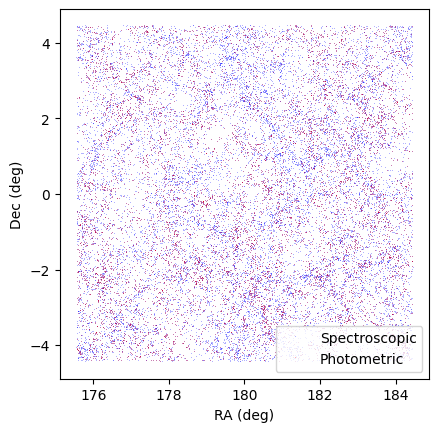

In [57]:
fig, ax = plt.subplots()
kwargs = dict(marker=',', ls='None', alpha=0.3)
ax.plot(ra_spec, dec_spec, c='b', label='Spectroscopic', **kwargs)
ax.plot(ra_phot, dec_phot, c='r', label='Photometric', **kwargs)
ax.set_aspect('equal')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.legend()

In [58]:
# random catalog for photometric sample
nd1 = len(gal_pos_phot)
ra_rand_phot = np.random.uniform(min(ra_phot), max(ra_phot), nd1)
dec_rand_phot = np.random.uniform(min(dec_phot), max(dec_phot), nd1)

# separation bins
nbins = 10
bins = np.logspace(np.log10(0.001), np.log10(5.), nbins+1)

In [59]:
xcorrs = np.empty((nslices, nbins))
for i, spec_slice in enumerate(slices_spec):
    # prep spectroscopic slice and corresponding random set
    nd2 = len(spec_slice)
    gal_pos_ = np.copy(spec_slice.value)
    gal_pos_[:,2] = 0
    ra_spec_, dec_spec_ = CartesiantoEquatorial(gal_pos_, observer=[0.,0.,r.value])
    ra_rand_spec_ = np.random.uniform(min(ra_spec_), max(ra_spec_), nd2)
    dec_rand_spec_ = np.random.uniform(min(dec_spec_), max(dec_spec_), nd2)
    
    # compute xcorr
    thetaavg, xcorrs[i] = wtheta_cross(ra_phot, dec_phot, ra_spec_, dec_spec_, ra_rand_spec_, dec_rand_spec_, bins)

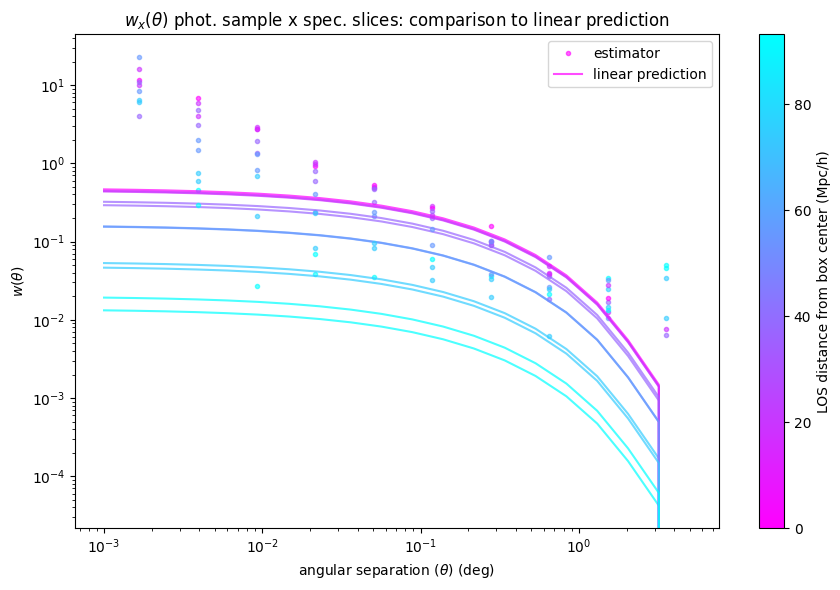

In [60]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig, ax = plt.subplots(figsize=(9,6))

for i, xcorr in enumerate(xcorrs):
    c = smap.to_rgba(np.abs(slice_centers[i].value))
    label_data = f'estimator' if i==5 else ''
    label_pred = f'linear prediction' if i==5 else ''
    ax.plot(thetaavg, xcorr, marker='.', ls='None', alpha=0.6, c=c, label=label_data)
    ax.plot(np.rad2deg(theta), wlin_pred[i], ls='-', alpha=0.7, c=c, label=label_pred)

ax.set_xlabel(r'angular separation ($\theta$) (deg)')
ax.set_ylabel(r'$w(\theta)$')
ax.loglog()
ax.legend()

fig.colorbar(smap, ax=ax, label='LOS distance from box center (Mpc/h)')
ax.set_title(r'$w_x(\theta)$ phot. sample x spec. slices: comparison to linear prediction')
fig.tight_layout()